In [1]:
import os
import os.path
import glob
import pandas as pd
import numpy as np
from PIL import Image
import preprocessing as proc
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

pd.options.display.max_columns = 1000

DATA_PATH = '../datasets/'
SUFFIX = 'normbg_'
CYTOPLASM = True
ZERNIKE = True
BIOMARKERS = True
CAPPED = False

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Load background measurements

In [2]:
bg = pd.DataFrame()

# Load each dataset and add stiffness column
for s in ("0.2", "0.5", "2", "8", "16", "32", "64"):
    tmp = pd.read_csv(DATA_PATH + s + "-B-background.csv", index_col=0)
    tmp['stiffness'] = np.float(s)
    bg = pd.concat([bg, tmp], sort=True)
    
# Reset index
bg.reset_index(inplace=True, drop=True)

# Rename columns
bg.columns = ["channel", "bg_mean", "bg_median", "bg_sdt", "stiffness"]

# Add columns with combination, well, site
bg['combination'] = "B"
bg['well'] = bg.channel.str.split(pat = "-", expand=True)[0]
bg['site'] = bg.channel.str.split(pat = "-", expand=True)[1]

# Add a column with channel
bg['channel'] = bg.channel.str.split(pat = "-", expand=True)[2].str.split(pat = ".", expand=True)[0]

# Add a column with corresponding fluorophore (COMBINATION B !!!)
fluorophores = {'DAPI' : 'DAPI', 'WGA' : 'FITC', 'Vim' : 'AF568', 'Ker' : 'AF647'}
bg['fluorophore'] = bg.channel.map(fluorophores)

# Create label
bg = proc.create_label(bg, per_cell=False)

print(bg.shape)
bg.head()

(292, 10)


,channel,bg_mean,bg_median,bg_sdt,stiffness,combination,well,site,fluorophore,label
0,WGA,268.314,272,52.462,0.2,B,A1,1,FITC,0.2-B-A1-1
1,DAPI,48.874,49,2.755,0.2,B,A1,1,DAPI,0.2-B-A1-1
2,Vim,102.633,101,11.028,0.2,B,A1,1,AF568,0.2-B-A1-1
3,Ker,89.640,87,11.788,0.2,B,A1,1,AF647,0.2-B-A1-1
4,WGA,252.484,245,57.304,0.2,B,A1,2,FITC,0.2-B-A1-2


# Load cell measurements

In [3]:
measurements = proc.import_cell_data(data_path=DATA_PATH, suffix=SUFFIX, cytoplasm=CYTOPLASM, biomarkers=BIOMARKERS)

Morphology was measured for 610.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 610 cells.

The are no duplicated column names: True
Biomarkers were measured for 610 cells.

The are no duplicated column names: True

Full dataset has shape: (610, 555)


In [4]:
measurements = proc.clean_data(measurements)

Initial shape is: (610, 555)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga_cell', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga_cell', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centermassintensityZ_wga_nucl',
       'loc_centerZ_nucl', 'loc_maxintensityZ_dapi',
       'loc_maxintensityZ_wga_nucl', 'centerZ_cyto',
       'loc_centermassintensityZ_ker', 'loc_centermassintensityZ_vim',
       'loc_centerZ', 'loc_maxintensityZ_ker', 'loc_maxintensityZ_vim'],
      dtype='object')

After cleaning the dataset has 610 rows and 496 columns.



In [5]:
measurements = proc.cv_ratio(measurements)

In [6]:
# Lists of column names
meta_cols = measurements.select_dtypes(include=['object', 'category']).columns
feature_cols = measurements.select_dtypes(include=[np.number]).columns
biom_cols = [col for col in measurements.columns if 'ker' in col or 'vim' in col]
biom_cols.append('cvratio')
biom_cols.append('log_cvratio')
morph_cols = [col for col in feature_cols if col not in biom_cols]

In [7]:
biomarkers = pd.concat([measurements[meta_cols], measurements[biom_cols]], axis=1)

In [8]:
palette = sns.color_palette("Set3", 7)

# Changes in background

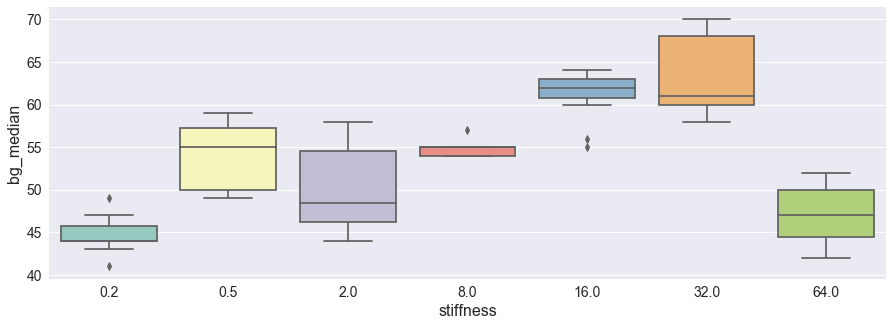

In [9]:
sns.boxplot(x='stiffness', y='bg_median', data=bg[bg.channel=='DAPI'], palette=palette);

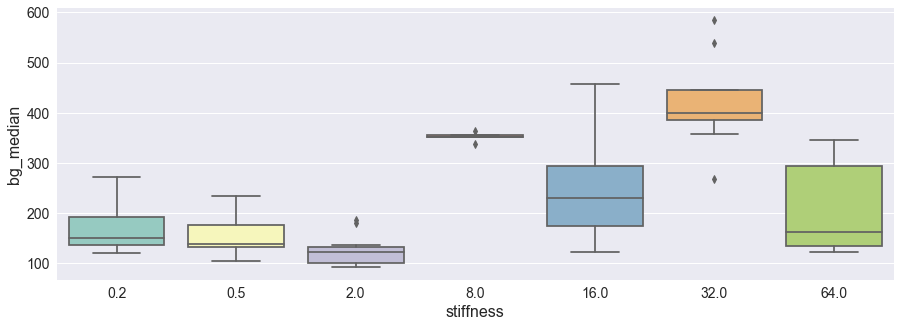

In [10]:
sns.boxplot(x='stiffness', y='bg_median', data=bg[bg.channel=='WGA'], palette=palette);

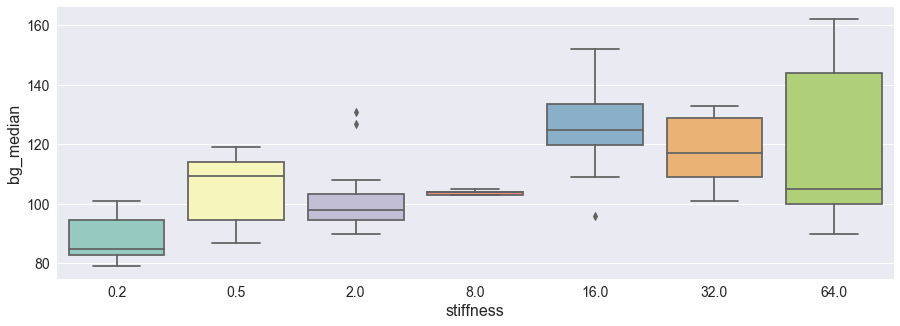

In [11]:
sns.boxplot(x='stiffness', y='bg_median', data=bg[bg.channel=='Vim'], palette=palette);

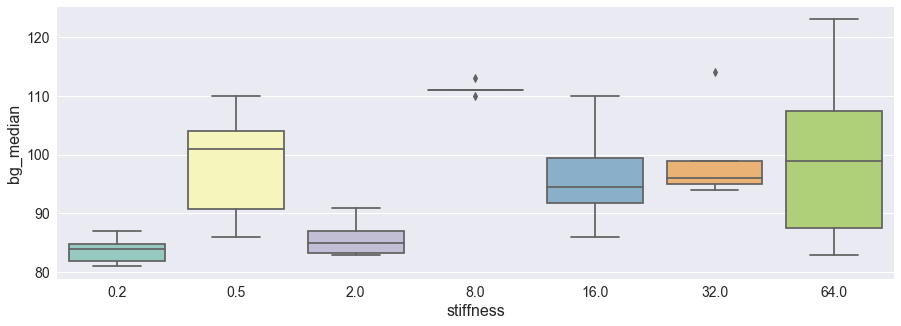

In [12]:
sns.boxplot(x='stiffness', y='bg_median', data=bg[bg.channel=='Ker'], palette=palette);

# Changes in cell signal

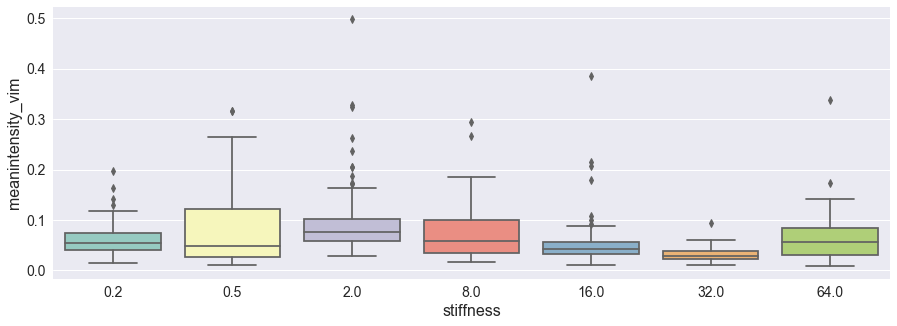

In [13]:
sns.boxplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_vim, palette=palette);

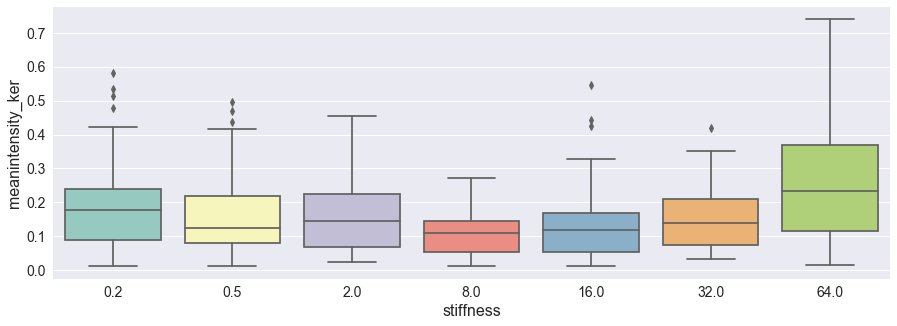

In [14]:
sns.boxplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_ker, palette=palette);

## Log transformation

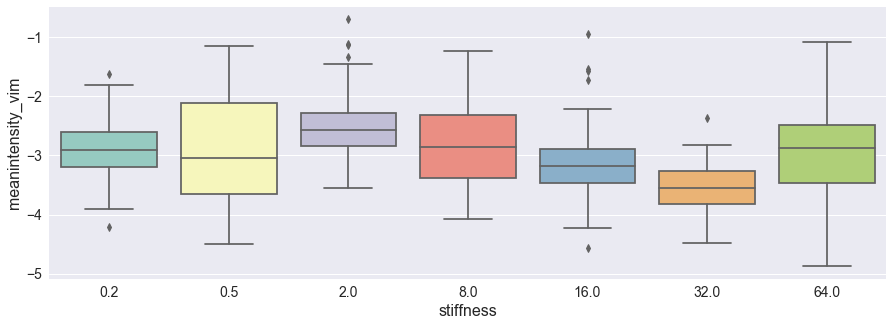

In [15]:
sns.boxplot(x=biomarkers.stiffness, y=np.log(biomarkers.meanintensity_vim), palette=palette);

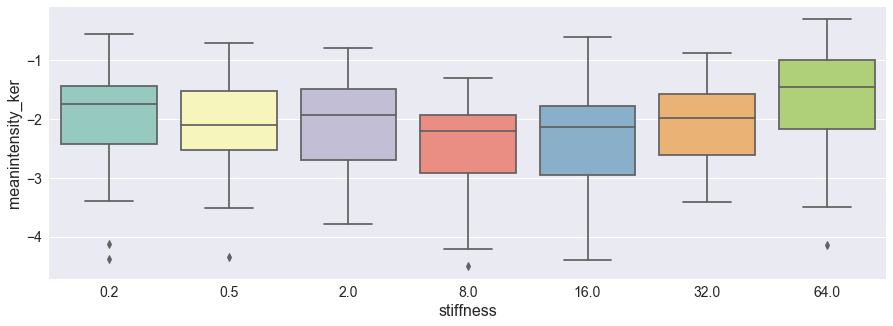

In [16]:
sns.boxplot(x=biomarkers.stiffness, y=np.log(biomarkers.meanintensity_ker), palette=palette);

## Signal vs background

In [25]:
tmp = bg[bg.channel == 'Ker'].copy().reset_index(drop=True)
tmp = tmp.join(pd.DataFrame(measurements.groupby('image').meanintensity_ker.median()).reset_index(drop=True))

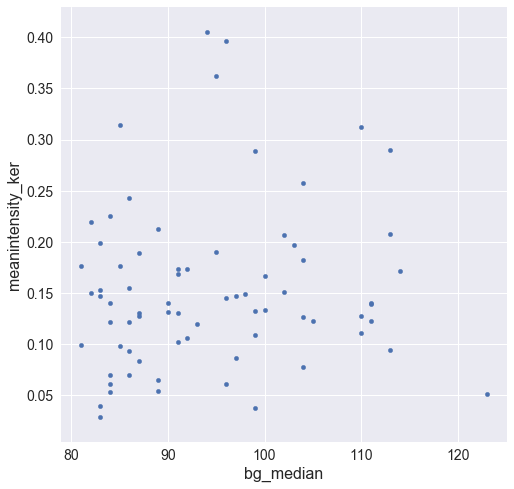

In [26]:
tmp.plot(kind='scatter', x='bg_median', y='meanintensity_ker', figsize=(8, 8));

In [27]:
tmp[['bg_median', 'meanintensity_ker']].corr()

,bg_median,meanintensity_ker
bg_median,1.000000,0.111076
meanintensity_ker,0.111076,1.000000


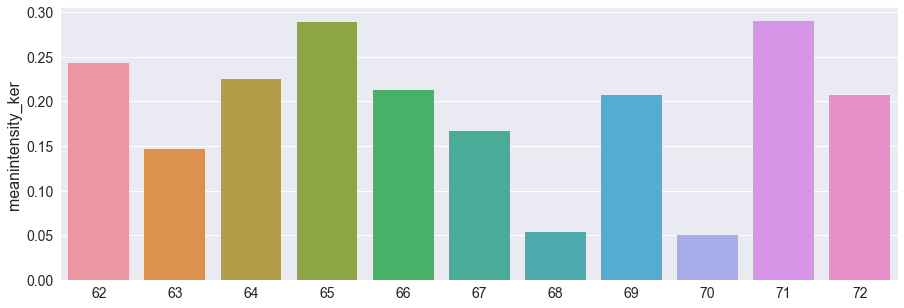

In [32]:
sns.barplot(x=tmp[tmp.stiffness=='64.0'].index, y=tmp[tmp.stiffness=='64.0'].meanintensity_ker);